In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches

# Setting a random seed for reproducibility
np.random.seed(42)

# Generating date range for one month (30 days)
date_range = pd.date_range(start='2023-01-01', periods=30, freq='D')

# Generating data with temporal structure
feature_1 = np.sin(np.linspace(0, 3 * np.pi, 30))  # Sine wave for cyclical pattern
feature_2 = np.linspace(0, 10, 30) + np.random.randn(30)  # Linear trend with noise

# Creating the DataFrame
data = {
    'Datetime': date_range,
    'feature_1': feature_1,
    'feature_2': feature_2
}
df = pd.DataFrame(data)


def plot_time_series(df):
    mpl.rcParams.update(mpl.rcParamsDefault)  # Reset the default style
    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()
    
    # Ensure the DataFrame has a 'date' column or index
    if 'Datetime' in df_copy.columns:
        # Set the 'date' column as the index for plotting
        df_copy.set_index('Datetime', inplace=True)
    
    # Ensure the date index is in datetime format
    df_copy.index = pd.to_datetime(df_copy.index)
    
    # Get the full date range for the x-axis
    full_date_range = pd.date_range(start=df_copy.index.min(), end=df_copy.index.max(), freq='D')
    
    # Iterate through each column and create a plot
    for column in df_copy.columns[:1]:
        plt.figure(figsize=(10, 6))
        plt.plot(df_copy.index, df_copy[column], marker='o', linestyle='-', color='blue')
        plt.xlim(full_date_range.min(), full_date_range.max())  # Ensure the full x-axis range is shown
        plt.xlabel('Datetime')
        plt.ylabel(column)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
        
def plot_time_series_diff(df, df_original, save_path=None):
    mpl.rcParams.update(mpl.rcParamsDefault)  # Reset the default style
    # Create copies of the dataframes to avoid modifying the originals
    df_copy = df.copy()
    df_original_copy = df_original.copy()
    
    # Ensure both DataFrames have a 'date' column or index
    if 'Datetime' in df_copy.columns:
        df_copy.set_index('Datetime', inplace=True)
    if 'Datetime' in df_original_copy.columns:
        df_original_copy.set_index('Datetime', inplace=True)
    
    # Ensure the date indices are in datetime format
    df_copy.index = pd.to_datetime(df_copy.index)
    df_original_copy.index = pd.to_datetime(df_original_copy.index)
    
    # Align both DataFrames to have the same date range
    df_copy, df_original_copy = df_copy.align(df_original_copy, join='outer')
    
    # Iterate through each column and create a plot
    for column in df_copy.columns[:1]:
        fig, ax = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'wspace': 0.1})
        
        # Plot the original time series
        ax[0].plot(df_original_copy.index, df_original_copy[column], marker='o', linestyle='-', label=f'{column} (Original)', color='blue')
        
        # Plot the modified time series
        ax[1].plot(df_copy.index, df_copy[column], marker='o', linestyle='-', label=f'{column} (Current)', color='blue')
        
        # Highlight differences in orange
        diff_mask = df_copy[column] != df_original_copy[column]
        ax[1].scatter(df_copy.index[diff_mask], df_copy[column][diff_mask], marker='o', color='red', label='Difference', zorder=3)
        
        # Set the same x and y limits for both plots with a small margin for better visualization
        x_min = min(df_copy.index.min(), df_original_copy.index.min())
        x_max = max(df_copy.index.max(), df_original_copy.index.max())
        y_min = min(df_copy[column].min(), df_original_copy[column].min())
        y_max = max(df_copy[column].max(), df_original_copy[column].max())
        margin = 0.05 * (y_max - y_min)
        
        ax[0].set_xlim(x_min, x_max)
        ax[1].set_xlim(x_min, x_max)
        ax[0].set_ylim(y_min - margin, y_max + margin)
        ax[1].set_ylim(y_min - margin, y_max + margin)
        
        # Remove axis labels and ticks
        for a in ax:
            a.set_xlabel('')
            a.set_ylabel('')
            a.set_xticks([])
            a.set_yticks([])
            a.grid(True, linestyle='--', alpha=0.7)
        
        # Add an arrow annotation between the plots, centered and shorter
        arrow = patches.FancyArrowPatch((0.5, 0.4925), (0.5275, 0.4925), transform=fig.transFigure,
                                        color='black', arrowstyle='->', mutation_scale=15, linewidth=2)
        fig.patches.append(arrow)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, format = 'pdf', bbox_inches='tight', pad_inches=0.01)
        else:
            plt.show()
        
import random

def unique_seed_generator(base_seed: int):
    """
    A generator function that yields unique random seeds based on a base seed.

    Parameters
    ----------
    base_seed : int
        The initial seed to ensure consistency.

    Yields
    ------
    int
        A unique random seed.
    """
    rng = random.Random(base_seed)
    seeds = set()

    while True:
        seed = rng.randint(0, 2**32 - 1)
        if seed not in seeds:
            seeds.add(seed)
            yield seed
            
def generate_error_distribution(total_error_rate, num_segments, seed = None):
    """Generate random segments of a total error rate, each segment being a part of the total.

    Args:
        total_error_rate (float): The total error rate to be distributed.
        num_segments (int): The number of random segments to generate.

    Yields:
        float: A part of the total error rate, each call yields a segment.
    """
    if seed is not None:
        random.seed(seed)
    
    random_parts = [random.random() for _ in range(num_segments)]
    sum_of_parts = sum(random_parts)
    
    for part in random_parts:
        yield part / sum_of_parts * total_error_rate

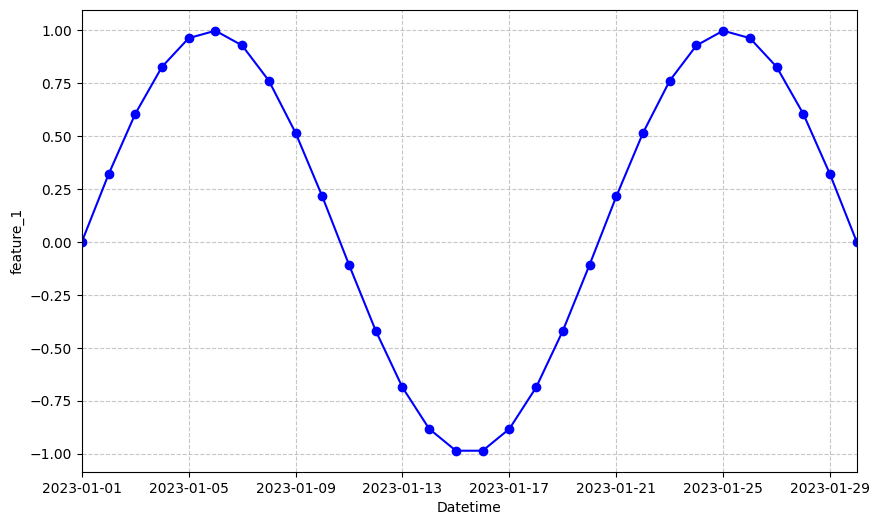

In [39]:
plot_time_series(df)

In [22]:
from error_generation.api.mid_level import create_errors, MidLevelConfig
from error_generation.error_mechanism import EAR
from error_generation.error_type import MissingValue
from error_generation.utils import ErrorModel

mechanism = EAR(condition_to_column='date', seed=42)
error_type = MissingValue()
features = df.columns[1:]

error_config = MidLevelConfig(
    {
        "feature_1": [ErrorModel(error_mechanism=mechanism, error_type=error_type, error_rate=0.05),
                        ErrorModel(error_mechanism=mechanism, error_type=error_type, error_rate=0.05)],
        "feature_2": [ErrorModel(error_mechanism=mechanism, error_type=error_type, error_rate=0.05),
                      ErrorModel(error_mechanism=mechanism, error_type=error_type, error_rate=0.05)]
    }
)

num_models = 3
seed_generator = unique_seed_generator(727)
error_rate = 0.2
error_dist_gen = generate_error_distribution(error_rate, num_models, seed=727)
error_models = [
        ErrorModel(error_mechanism=EAR(condition_to_column='date', seed = next(seed_generator)), error_type=error_type, error_rate=next(error_dist_gen))
        for _ in range(num_models)
    ]
error_config_test = MidLevelConfig(
    {feature : error_models for feature in features}
)

df_corrupted, error_mask = create_errors(df, error_config_test)


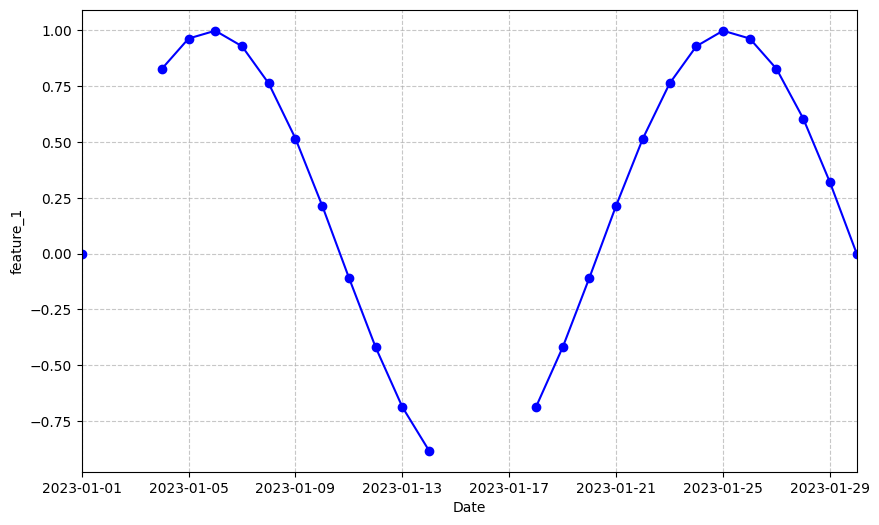

In [23]:
plot_time_series_diff(df_corrupted, df)

In [90]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

from utils.ErrorGeneration import ErrorGeneration

ErrorGeneration.ERROR_SEGMENTS = 3

data_missing = ErrorGeneration._apply_missing_values(df, ['feature_1'], 0.4, True)
data_outlier = ErrorGeneration._apply_outliers(df, ['feature_1'], 0.35, 1, 0.1)
data_clipping = df.copy()
data_clipping['feature_1'] = data_clipping['feature_1'].clip(-0.7, 0.7)

plot_time_series_diff(data_missing, df, save_path='missing_value_explanation.pdf')
plot_time_series_diff(data_outlier, df, save_path='outlier_explanation.pdf')
plot_time_series_diff(data_clipping, df, save_path='clipping_explanation.pdf')

INFO:utils.ErrorGeneration:Applied MissingValue to the data.
INFO:utils.ErrorGeneration:Applied Outlier to the data.
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_99869/2347223262.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_99869/2347223262.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_99869/2347223262.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
